In [1]:
# ensemble methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('composite_df.pkl')
df['time_until_reading_hr'] = 24 - df['time_until_reading_hr']
df_g = df.groupby(['day_id', 'st_code'])


In [3]:
# just check that every thing is ordered
df[['st_code','day_id','gate_time','time_until_reading_hr']].head(30)

,st_code,day_id,gate_time,time_until_reading_hr
0,agp,13,2017-01-15 07:57:39,24.0
1,agp,13,2017-01-15 06:00:45,22.0
2,agp,13,2017-01-15 04:03:51,20.0
3,agp,13,2017-01-15 01:58:13,18.0
4,agp,13,2017-01-15 00:02:26,16.0
5,agp,14,2017-01-16 06:08:38,22.2
6,agp,14,2017-01-16 06:05:06,22.0
7,agp,14,2017-01-16 03:59:29,20.0
8,agp,14,2017-01-16 02:02:37,18.0
9,agp,14,2017-01-16 00:09:13,16.2


kill reflectivity data below 12 dB, which is likely noise

In [4]:
# exp1 if cond else exp2
affected = ('refl_2000', 'refl_3000', 'refl_4000', 'refl_5000', 'refl_6000')
for col in affected:
    df[col].apply(lambda ref: 0 if ref < 12 else ref)


get simple means

In [5]:
df.columns

Index(['day_id', 'difphase_2000', 'difphase_3000', 'difphase_4000',
       'difphase_5000', 'difphase_6000', 'elev_m', 'expected_mm', 'gate_time',
       'lat', 'lon', 'r_dist_km', 'r_elev_delta_m', 'refl_2000', 'refl_3000',
       'refl_4000', 'refl_5000', 'refl_6000', 'st_code', 'time_until_reading',
       'time_until_reading_hr', 'velocity_2000', 'velocity_3000',
       'velocity_4000', 'velocity_5000', 'velocity_6000', 'xcorr_ratio_2000',
       'xcorr_ratio_3000', 'xcorr_ratio_4000', 'xcorr_ratio_5000',
       'xcorr_ratio_6000'],
      dtype='object')

In [6]:
to_df = []
dates = []
sensors = []
for k,grp in df_g:
    sensors.append(grp.st_code.iloc[0])
    dates.append(grp.gate_time.iloc[0])
    to_df.append(grp.mean())

df_mean = pd.DataFrame.from_dict(to_df)
df_mean['dates'] = pd.Series(dates)
df_mean['st_code'] = pd.Series(sensors)  

#drop negative snowfall (meltoff)
print(df_mean.shape)
df_mean = df_mean[df_mean.expected_mm > -40]
print(df_mean.shape)

# automatically drops non-numeric columns
X = df_mean.drop(['day_id','expected_mm', 'time_until_reading', 'time_until_reading_hr', 'dates', 'st_code'], axis=1)
y = df_mean['expected_mm'] #- df_mean['expected_mm'].min() +1

(723, 31)
(722, 31)


get weighted means

In [181]:
# from https://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns/35327787#35327787
def weighed_average(grp):
    return grp._get_numeric_data().multiply(grp['time_until_reading_hr'], axis=0).sum()/grp['time_until_reading_hr'].sum()

#df.groupby('SOME_COL').apply(weighed_average)

#df_to_wt = df.drop(['time_until_reading', 'gate_time'],axis=1)[['st_code','refl_6000', 'time_until_reading_hr']]
df_wt = df.groupby(['day_id','st_code']).apply(weighed_average)
X = df_wt.drop(['day_id','expected_mm', 'time_until_reading_hr', 'dates'], axis=1)
y = df_wt['expected_mm']


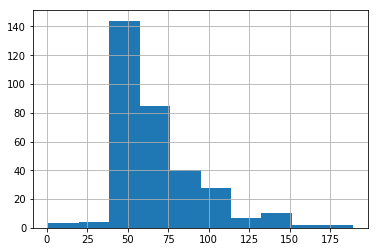

In [36]:
y.hist()
plt.show()

start modeling

In [10]:
#check columns
X.columns

Index(['difphase_2000', 'difphase_3000', 'difphase_4000', 'difphase_5000',
       'difphase_6000', 'elev_m', 'lat', 'lon', 'r_dist_km', 'r_elev_delta_m',
       'refl_2000', 'refl_3000', 'refl_4000', 'refl_5000', 'refl_6000',
       'velocity_2000', 'velocity_3000', 'velocity_4000', 'velocity_5000',
       'velocity_6000', 'xcorr_ratio_2000', 'xcorr_ratio_3000',
       'xcorr_ratio_4000', 'xcorr_ratio_5000', 'xcorr_ratio_6000'],
      dtype='object')

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

upsample the train set

In [180]:
df['bucket'] = pd.cut(df['expected_mm'], bins=7, labels=False)

temp_df = df[['bucket', 'seq_id', 'expected_mm']].drop_duplicates(subset='seq_id').reset_index(drop=True)
temp_df['bucket'] = pd.cut(temp_df['expected_mm'], bins=7, labels=False)
temp_df['bucket'].value_counts()

temp_df['expected_mm'].hist()
plt.show()

max_count = temp_df['bucket'].value_counts().max()
counts = dict(temp_df['bucket'].value_counts())

# must upsample
# generate seq_id based upsample temp dataframe 
# this is used to map out the main dataframe
from sklearn.utils import resample


upsamples = []
for c in counts:
    to_be_upsampled = temp_df[temp_df.bucket == c]
    #if counts[c] != max_count:
    to_be_upsampled = resample(to_be_upsampled, 
                             replace=True,     # sample with replacement
                             n_samples=max_count,    # to match majority class
                             random_state=123) 
    upsamples.append(to_be_upsampled)

temp_df_up = pd.concat(upsamples)
temp_df_up.sort_values("seq_id", inplace=True)
temp_df_up.reset_index(inplace=True, drop=True)
del upsamples


temp_df_up['bucket'].hist(bins=10)
plt.show()

# now apply apply temp_df_up to actual dataframe
upsamples = []
df_b = df.groupby('bucket')
for i, bucket_group in df_b:
    sequences = temp_df_up[temp_df_up['bucket'] == i]['seq_id']
    seq_list = []
    g_g = bucket_group.groupby('seq_id')
    for seq in sequences:
        seq_list.append(g_g.get_group(seq))
    upsamples.append(pd.concat(seq_list))
df_upsampled = pd.concat(upsamples)

df_upsampled.expected_mm.hist()
plt.show()
# keras class weight

KeyError: "['seq_id'] not in index"

In [12]:
%%time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

param_grid_rf = {'n_estimators':    [100, 200],
                 'n_jobs':          [-1],
                 'max_features':    [3,4,5,6,7], 
                 'oob_score':       [True],
                 'criterion':       ['mse'],
                 'max_depth':       [11,12,18, 20],
                 'min_samples_leaf':[1,2,3,4]}

param_grid_xgb = {'n_estimators':   [80, 90, 100],
                  'n_jobs':         [-1],
                  'learning_rate':  [.05,.07,.1, .2], 
                  'subsample':      [.6, .7, .8],
                  'max_depth':      [3,4,5],
                  'reg_alpha':      [9,12,14],
                  'reg_lambda':     [16,18,22]}

models = {
    'xgbr': GridSearchCV(XGBRegressor(), param_grid=param_grid_xgb,cv=2, scoring='neg_mean_squared_error', verbose =1),
    'rfr': GridSearchCV(RandomForestRegressor(), param_grid=param_grid_rf, cv=2, scoring='neg_mean_squared_error',verbose =1), # slow
}
# add votingclassifier after param search
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

for m in models.keys():
    print('training ' + m)
    models[m].fit(X_train, y_train)
    y_pred_train = models[m].predict(X_train)
    y_pred = models[m].predict(X_test)

    print(models[m].best_estimator_)
    print('train mae: ', mean_absolute_error(y_train, y_pred_train))
    print('test mae:  ', mean_absolute_error(y_test, y_pred), '\n')


training xgbr
Fitting 2 folds for each of 972 candidates, totalling 1944 fits


[Parallel(n_jobs=1)]: Done 1944 out of 1944 | elapsed:  2.7min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=14, reg_lambda=18, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)
train mae:  5.40688279531
test mae:   8.98220969594 

training rfr
Fitting 2 folds for each of 160 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  3.3min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)
train mae:  4.81696307937
test mae:   8.76451959542 

CPU times: user 5min 10s, sys: 27.1 s, total: 5min 37s
Wall time: 5min 55s


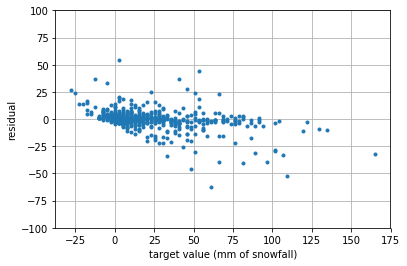

2.59613222508
8.98689340011


In [13]:
#xgbr = models['xgbr'].best_estimator_ 
# best with only positive snowfall
xgbr = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=8, reg_lambda=16, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

# best include meltoff
# xgbr = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=1, gamma=0, learning_rate=0.07, max_delta_step=0,
#        max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
#        n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
#        reg_alpha=14, reg_lambda=18, scale_pos_weight=1, seed=None,
#        silent=True, subsample=0.7)

xgbr.fit(X_train, y_train)
y_predict = xgbr.predict(X)
X_final = df_mean.copy()
X_final['predicted_mm'] = y_predict
X_final.to_pickle('xgb_results_meltoff.pkl')
#X = df_mean.drop(['day_id','expected_mm', 'time_until_reading'], axis=1)
#y = df_mean['expected_mm']
plt.plot(X_final['expected_mm'], X_final['predicted_mm']-X_final['expected_mm'],'.')
plt.ylabel('residual')
plt.xlabel('target value (mm of snowfall)')
plt.ylim(-100, 100) 
plt.grid()
plt.show()

# mae
y_predict_train = xgbr.predict(X_train)
y_predict_test = xgbr.predict(X_test)
print(mean_absolute_error(y_train,y_predict_train))
print(mean_absolute_error(y_test,y_predict_test))


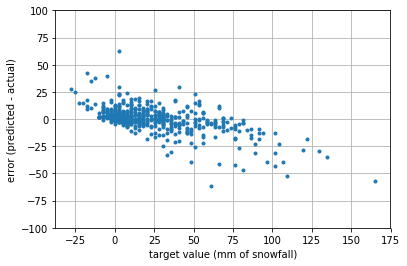

4.73150558699
8.68235385439


In [14]:
rfr  = models['rfr'].best_estimator_ 

# rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
#            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
#            min_impurity_split=None, min_samples_leaf=1,
#            min_samples_split=2, min_weight_fraction_leaf=0.0,
#            n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
#            verbose=0, warm_start=False)

rfr.fit(X_train, y_train)
y_predict = rfr.predict(X)
X_final = df_mean.copy()
X_final['predicted_mm'] = y_predict
X_final.to_pickle('rf_results.pkl')
#X = df_mean.drop(['day_id','expected_mm', 'time_until_reading'], axis=1)
#y = df_mean['expected_mm']
plt.plot(X_final['expected_mm'], X_final['predicted_mm']-X_final['expected_mm'],'.')
plt.ylabel('error (predicted - actual)')
plt.xlabel('target value (mm of snowfall)')
plt.ylim(-100, 100) 
plt.grid()
plt.show()

# mae
y_predict_train = rfr.predict(X_train)
y_predict_test = rfr.predict(X_test)
print(mean_absolute_error(y_train,y_predict_train))
print(mean_absolute_error(y_test,y_predict_test))


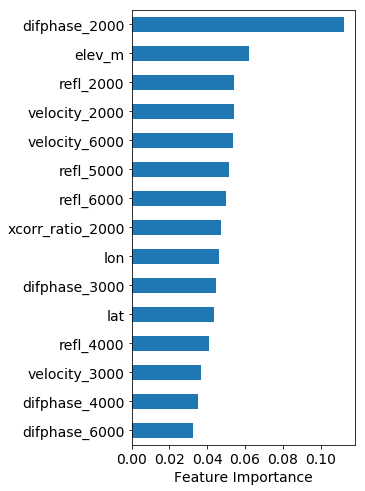

In [16]:
# top 15
fi_dict = {a[0]:a[1] for a in zip(list(X.columns), list(xgbr.feature_importances_))}
features_importance = pd.DataFrame.from_dict(fi_dict, orient='index')

fi = features_importance.sort_values(by=[0], ascending=True)
fi.iloc[-15:].plot.barh(stacked=True, legend=False, figsize = (4,8), fontsize = 14)
plt.xlabel('Feature Importance', fontsize=14)
plt.savefig('foo.pdf', bbox_inches='tight')
plt.show()

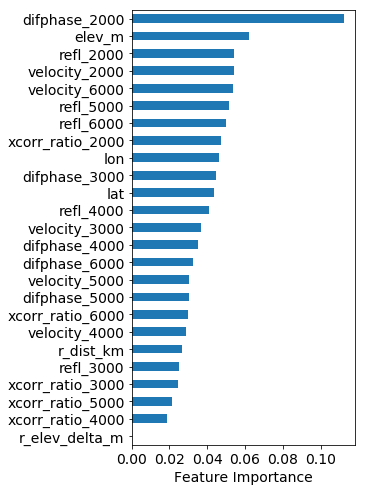

In [17]:
# top 15
fi_dict = {a[0]:a[1] for a in zip(list(X.columns), list(xgbr.feature_importances_))}
features_importance = pd.DataFrame.from_dict(fi_dict, orient='index')

fi = features_importance.sort_values(by=[0], ascending=True)
fi.plot.barh(stacked=True, legend=False, figsize = (4,8), fontsize = 14)
plt.xlabel('Feature Importance', fontsize=14)
plt.savefig('foo.pdf', bbox_inches='tight')
plt.show()